### Q2: *Predicting Mental Illness*

*Install Python libraries*

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from data.visualize import display_column_count_hist, display_features_by_count, display_feature_importance, display_correration_matrix

*Ingest Data*

In [2]:
source_dataset = pd.read_csv('./../data/depression_analysis/depression_data.csv')
currated_dataset = source_dataset.copy()

*Visualise Data*


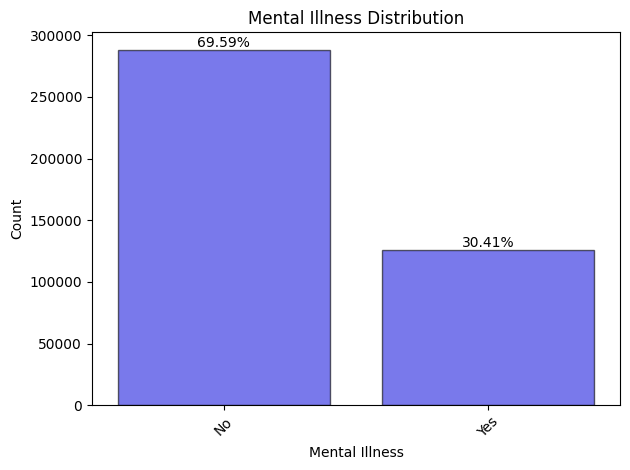

In [3]:
display_features_by_count(
    dataset=source_dataset,
    feature_name='History of Mental Illness',
    title='Mental Illness Distribution',
    xlabel='Mental Illness'
    )

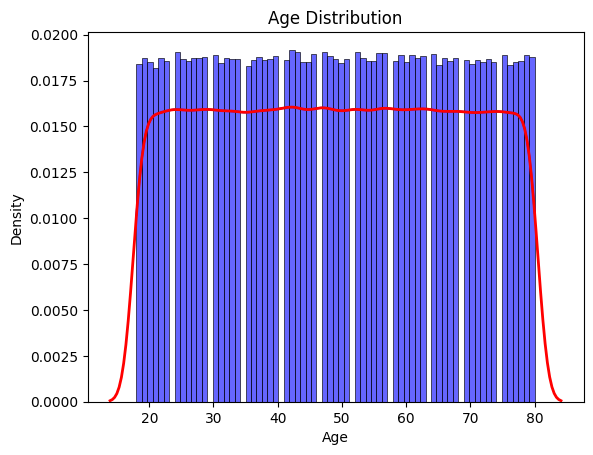

In [4]:
display_column_count_hist(
    source_dataset=source_dataset,
    column_name="Age",
)

*Hypothesis: Age is quite granular. Is there statistical power in whether an individual is more suscepible to depression if they are 18 or 19? Intuition would suggest not. Age ranges, for example, 18-30, may have more predictive power, as cohorts within similar age groups may have distinct characters at a generational level.*

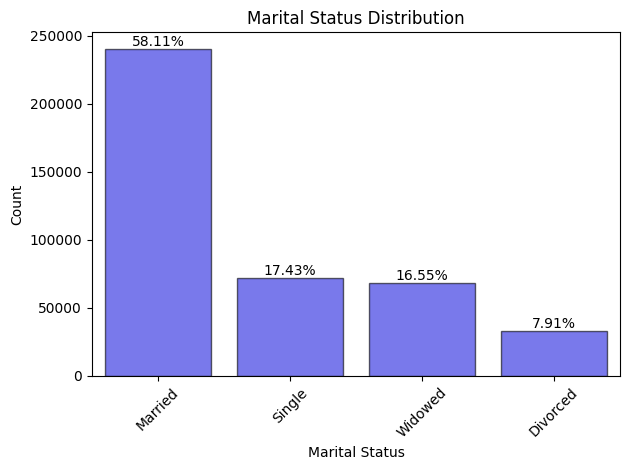

In [5]:
display_features_by_count(
    dataset=source_dataset,
    feature_name='Marital Status',
    title='Marital Status Distribution',
    xlabel='Marital Status'
    )



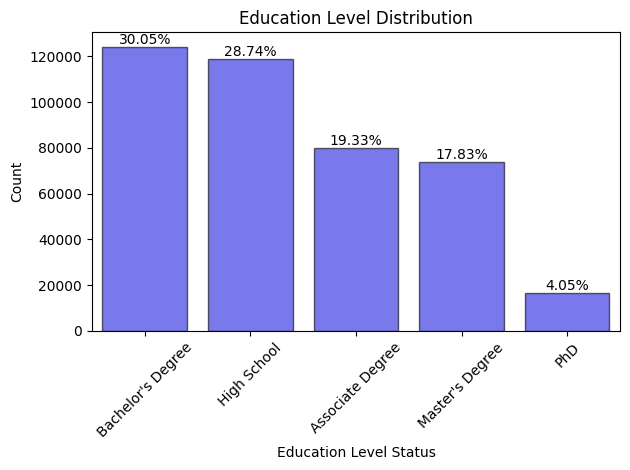

In [6]:
display_features_by_count(
    dataset=source_dataset,
    feature_name='Education Level',
    title='Education Level Distribution',
    xlabel='Education Level Status'
    )

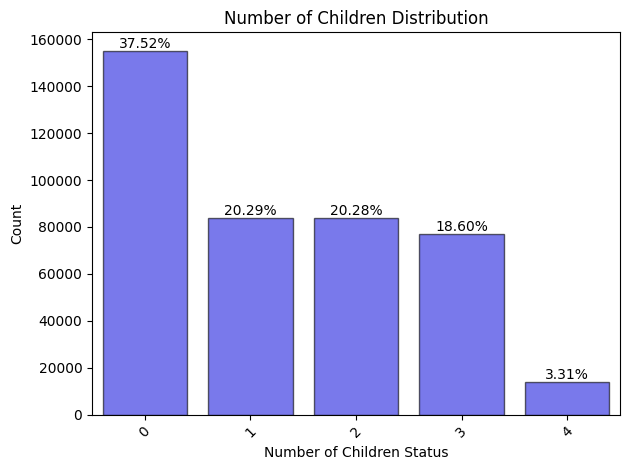

In [7]:
display_features_by_count(
    dataset=source_dataset,
    feature_name='Number of Children',
    title='Number of Children Distribution',
    xlabel='Number of Children Status')

*Display Summary Statistics & Dataset Feature Types*

In [8]:
source_dataset.describe()
# Information is limited owing to multiple data columns not yet being encoded.

,Age,Number of Children,Income
count,413768.000000,413768.000000,413768.000000
mean,49.000713,1.298972,50661.707971
std,18.158759,1.237054,40624.100565
min,18.000000,0.000000,0.410000
25%,33.000000,0.000000,21001.030000
50%,49.000000,1.000000,37520.135000
75%,65.000000,2.000000,76616.300000
max,80.000000,4.000000,209995.220000


In [9]:
source_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413768 entries, 0 to 413767
Data columns (total 16 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Name                          413768 non-null  object 
 1   Age                           413768 non-null  int64  
 2   Marital Status                413768 non-null  object 
 3   Education Level               413768 non-null  object 
 4   Number of Children            413768 non-null  int64  
 5   Smoking Status                413768 non-null  object 
 6   Physical Activity Level       413768 non-null  object 
 7   Employment Status             413768 non-null  object 
 8   Income                        413768 non-null  float64
 9   Alcohol Consumption           413768 non-null  object 
 10  Dietary Habits                413768 non-null  object 
 11  Sleep Patterns                413768 non-null  object 
 12  History of Mental Illness     413768 non-nul

*Data Wrangling*

*Data is well currated, therefore wrangling is minimal. We need to encode the Data*

*Finally, the "name" column, i.e. the name of the individual should have no statistical power on the incidence of mental health. It will be removed (at the training stage)*



In [10]:
# Define encoding settings
encoding_settings = {
    "Education Level": {"PhD": 4, "Master's Degree": 3, "Bachelor's Degree": 2, "Associate Degree": 1, "High School": 0},
    "Marital Status": {"Married": 3, "Divorced": 2, "Widowed": 1, "Single": 0},
    "Smoking Status": {"Non-smoker": 2, "Former": 1, "Current": 0},
    "Physical Activity Level": {"Sedentary": 2, "Moderate": 1, "Active": 0},
    "Employment Status": {"Employed": 1, "Unemployed": 0},
    "Dietary Habits": {"Healthy": 2, "Unhealthy": 1, "Moderate": 0},
    "Sleep Patterns": {"Good": 2, "Fair": 1, "Poor": 0},
    "Alcohol Consumption": {"High": 2, "Moderate": 1, "Low": 0},
}
    
# Apply the encoding settings
currated_dataset = currated_dataset.replace({'Yes': 1, 'No': 0})
currated_dataset.replace(encoding_settings, inplace=True)

C:\Users\ciaranh\AppData\Local\Temp\ipykernel_19204\2766745777.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  currated_dataset = currated_dataset.replace({'Yes': 1, 'No': 0})
C:\Users\ciaranh\AppData\Local\Temp\ipykernel_19204\2766745777.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  currated_dataset.replace(encoding_settings, inplace=True)


*Feature Engineering*

*Previously it was suggested that the continuous nature of the "Age" feature may be too granular, and therefore loose potentially significant information on generational affect. Create age ranges.*

*Feature Selection: "Name will be dropped". Given the subjectivity of this process, bias can create issues. I will first train the model and then use other statistical methods to derive feature importance. This insight will inform the feature selection*

In [11]:
#Define age groups and their corresponding labels
def age_group(age):
    if age <= 20:
        return 0
    elif 20 <= age <= 30:
        return 1
    elif 30 <= age <= 40:
        return 2
    elif 40 <= age <= 50:
        return 3
    elif 50 <= age <= 60:
        return 4
    elif 60 <= age <= 70:
        return 5
    elif 70 <= age <= 80:
        return 5

# Apply the age grouping to the dataset
currated_dataset['Age'] = currated_dataset['Age'].apply(age_group)

# *Machine Learning*

*Model Selection*

That data is non-linear, and it's size is medium to large, therefore models such as Gradient Boost and Random Forests will be ideal. Speed is a key consideration for me, which is why I leaned towards XGBoost initally. The XGBoost model also offered slight increase in perfromance. 

That said, Random Forests does offer distinct advantages in terms of interpretability. Given that explainability is central to the core problem statement, i.e what drives mental health illness, I decided to lean towards this model instead.

In [12]:
currated_dataset = currated_dataset.drop(columns=['Name'])
X = currated_dataset.drop(columns=['History of Mental Illness'])
y = currated_dataset['History of Mental Illness']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# # Initialize and train the RandomForestClassifier
# model = XGBClassifier(
#     objective='binary:logistic',
#     eval_metric='logloss',
#     use_label_encoder=False,
#     random_state=42,
    
# )

model = RandomForestClassifier(random_state=42)

model.fit(
    X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# # Calculate the accuracy of the model

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test, y_pred))



Accuracy: 0.64
              precision    recall  f1-score   support

           0       0.70      0.84      0.76     86319
           1       0.34      0.19      0.24     37812

    accuracy                           0.64    124131
   macro avg       0.52      0.51      0.50    124131
weighted avg       0.59      0.64      0.61    124131



*The accuracy is 69%, however this is not the full picture, and the value may be misleading when viewed in context of precision.*

*The model performs well in predicting whether a person has mental illness. I.e it has a 70% precision on successfully predicting class 0 ('No to Mental Health Issues.). Precision on successfully predicting class 1 ('Yes to Mental Health Issues') was very poor at 39%.*

*Given that the problem statement is to predict Mental Health Issues given a set of features, a low precision on class 1 makes the usefulnesss of the model fairly limited.*

*Therefore an accuracy of 69% creates a very distorted view. Recall for the positive class "1" is very low, indicating that the model is struggling to identifiy those with mental illness. The precision for class 1 is also low, meaning that when the model predicts "yes", it's often wrong. The model is likely overfitting to the majority class 0 ("No"), whicj the overwhelming part of the dataset (70% of the data)*

*Feature Selection*

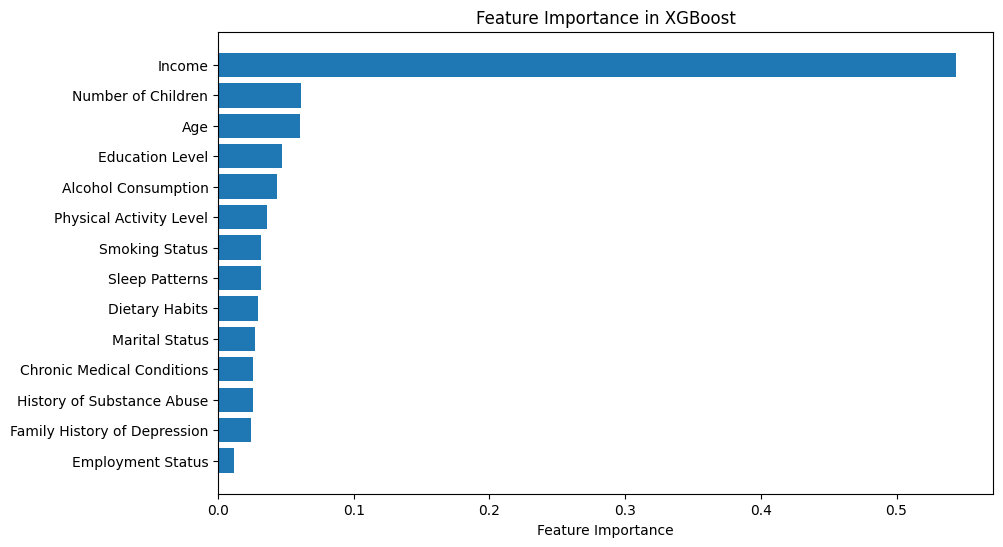

In [13]:
display_feature_importance(model, X)

*The feature importance makes interesting reading. Employment status is hughly important. All other features seem to have less influence on the predictor.*

*The findings potentially suggest that correlation or multicolinearity between features. For example, employment status would have a positve correlation on income.*

*Assessing correlation could aid the feature selection process*

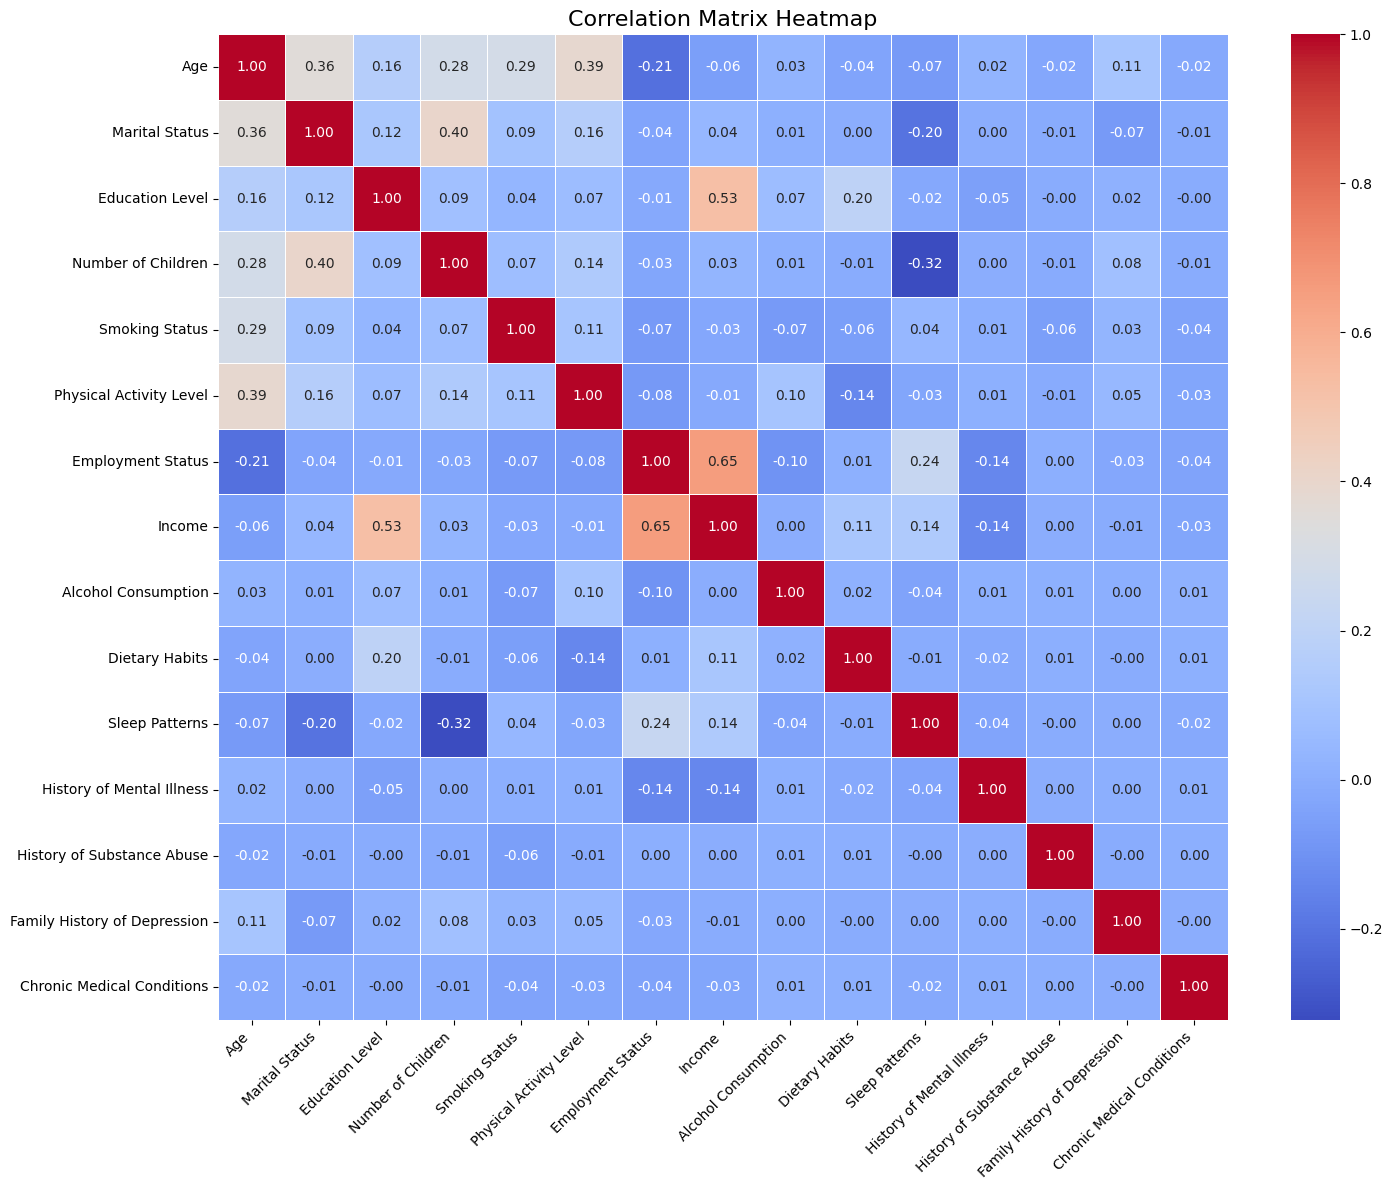

In [14]:
display_correration_matrix(currated_dataset)


I was somewhat surprised by these results as I thought correlation would be more prenounced across the features. 

The next step was to remove correlated features.

Accuracy: 0.64
              precision    recall  f1-score   support

           0       0.70      0.84      0.77    201305
           1       0.35      0.19      0.25     88333

    accuracy                           0.64    289638
   macro avg       0.52      0.52      0.51    289638
weighted avg       0.59      0.64      0.61    289638



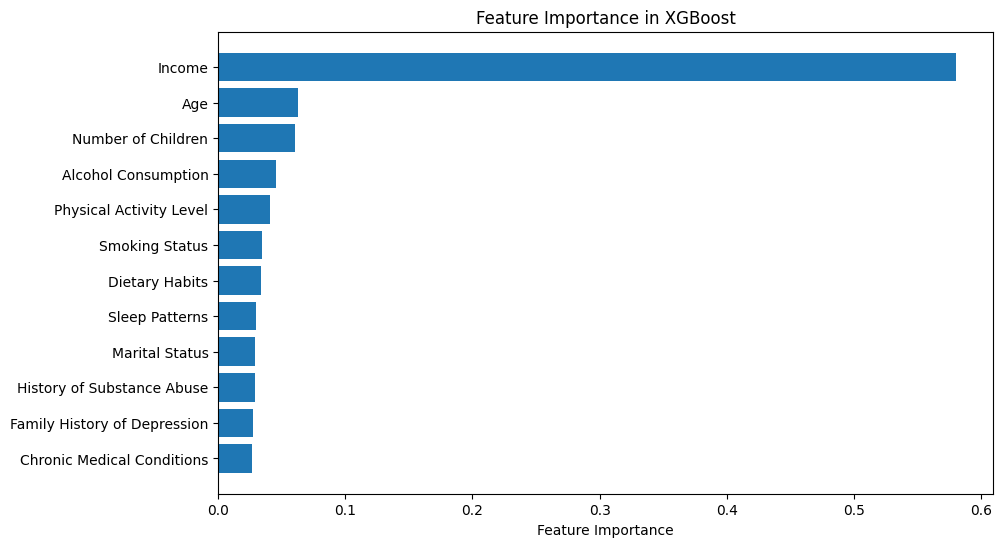

In [19]:
reduced_feature_df = currated_dataset.copy()
reduced_feature_df = currated_dataset.drop(columns=['Education Level', 'Employment Status'])

X = reduced_feature_df.drop(columns=['History of Mental Illness'])
y = reduced_feature_df['History of Mental Illness']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=42)

model.fit(
    X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# # Calculate the accuracy of the model

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test, y_pred))
display_feature_importance(model, X)

*No meaningful improvement*

*Next I investigate whether the distribution of the data. If there is a high degree of overlap, then it maybe the case that  existing features fail to distinguish between classes. As such, introducing more complex models, or removing feautures may not improve improvement, as the model will struggle to draw a decision boundeary between class 0 and class 1.*


C:\Users\ciaranh\AppData\Local\Temp\ipykernel_19204\2746211763.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(class_0[feature], label='No Depression (0)', shade=True, color='blue', bw_adjust=1.5)
C:\Users\ciaranh\AppData\Local\Temp\ipykernel_19204\2746211763.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(class_1[feature], label='Depression (1)', shade=True, color='red', bw_adjust=1.5)


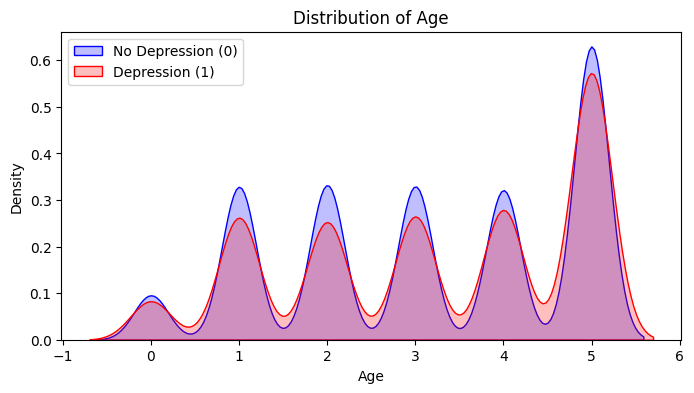

C:\Users\ciaranh\AppData\Local\Temp\ipykernel_19204\2746211763.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(class_0[feature], label='No Depression (0)', shade=True, color='blue', bw_adjust=1.5)
C:\Users\ciaranh\AppData\Local\Temp\ipykernel_19204\2746211763.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(class_1[feature], label='Depression (1)', shade=True, color='red', bw_adjust=1.5)


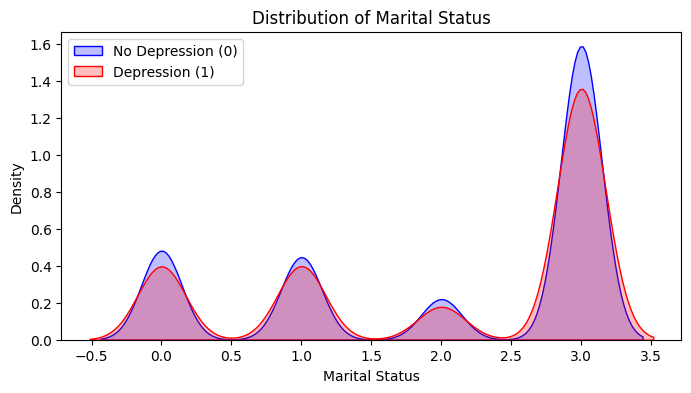

C:\Users\ciaranh\AppData\Local\Temp\ipykernel_19204\2746211763.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(class_0[feature], label='No Depression (0)', shade=True, color='blue', bw_adjust=1.5)
C:\Users\ciaranh\AppData\Local\Temp\ipykernel_19204\2746211763.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(class_1[feature], label='Depression (1)', shade=True, color='red', bw_adjust=1.5)


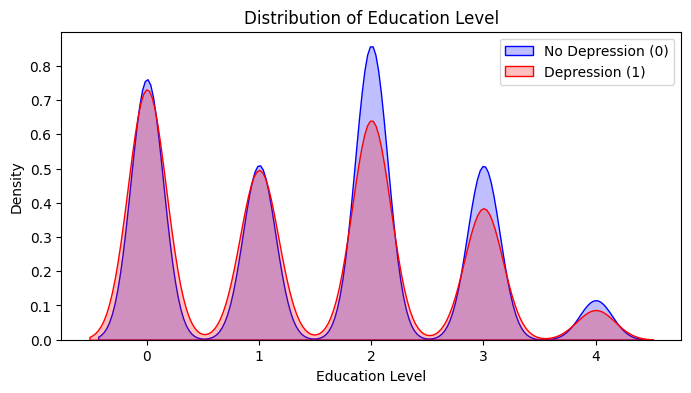

C:\Users\ciaranh\AppData\Local\Temp\ipykernel_19204\2746211763.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(class_0[feature], label='No Depression (0)', shade=True, color='blue', bw_adjust=1.5)
C:\Users\ciaranh\AppData\Local\Temp\ipykernel_19204\2746211763.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(class_1[feature], label='Depression (1)', shade=True, color='red', bw_adjust=1.5)


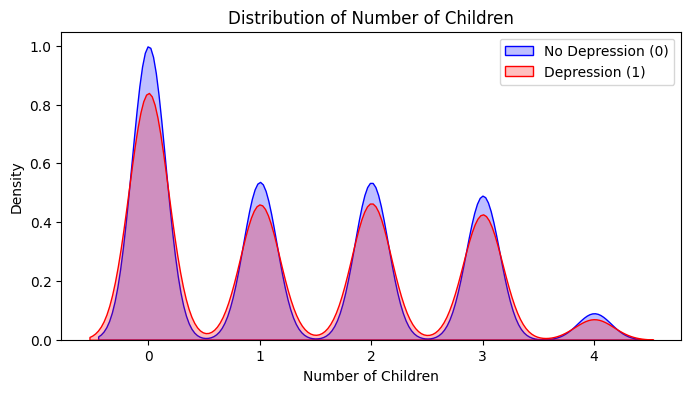

C:\Users\ciaranh\AppData\Local\Temp\ipykernel_19204\2746211763.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(class_0[feature], label='No Depression (0)', shade=True, color='blue', bw_adjust=1.5)
C:\Users\ciaranh\AppData\Local\Temp\ipykernel_19204\2746211763.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(class_1[feature], label='Depression (1)', shade=True, color='red', bw_adjust=1.5)


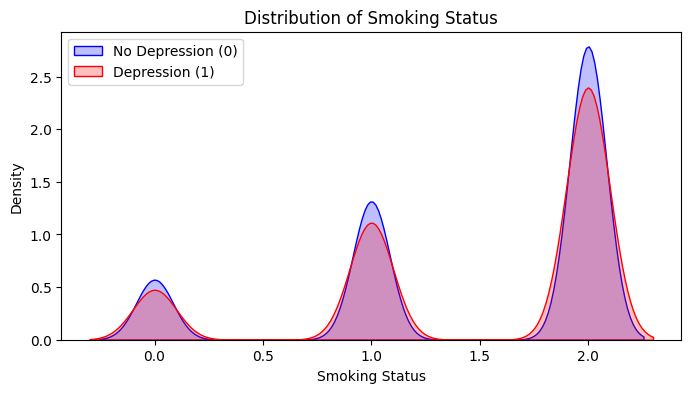

C:\Users\ciaranh\AppData\Local\Temp\ipykernel_19204\2746211763.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(class_0[feature], label='No Depression (0)', shade=True, color='blue', bw_adjust=1.5)
C:\Users\ciaranh\AppData\Local\Temp\ipykernel_19204\2746211763.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(class_1[feature], label='Depression (1)', shade=True, color='red', bw_adjust=1.5)


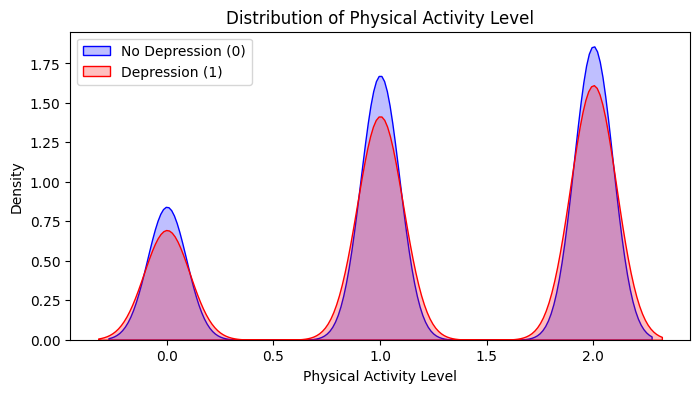

C:\Users\ciaranh\AppData\Local\Temp\ipykernel_19204\2746211763.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(class_0[feature], label='No Depression (0)', shade=True, color='blue', bw_adjust=1.5)
C:\Users\ciaranh\AppData\Local\Temp\ipykernel_19204\2746211763.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(class_1[feature], label='Depression (1)', shade=True, color='red', bw_adjust=1.5)


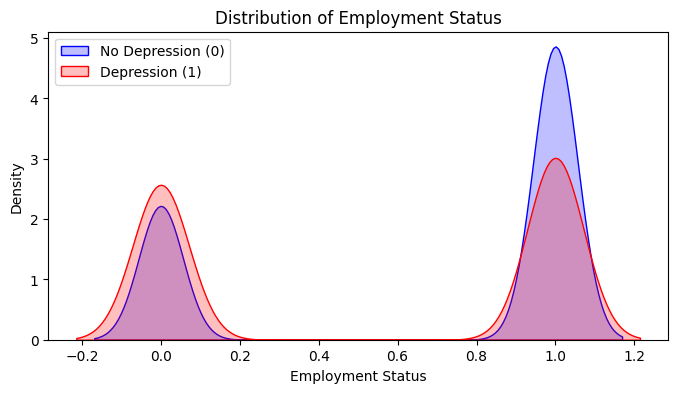

C:\Users\ciaranh\AppData\Local\Temp\ipykernel_19204\2746211763.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(class_0[feature], label='No Depression (0)', shade=True, color='blue', bw_adjust=1.5)
C:\Users\ciaranh\AppData\Local\Temp\ipykernel_19204\2746211763.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(class_1[feature], label='Depression (1)', shade=True, color='red', bw_adjust=1.5)


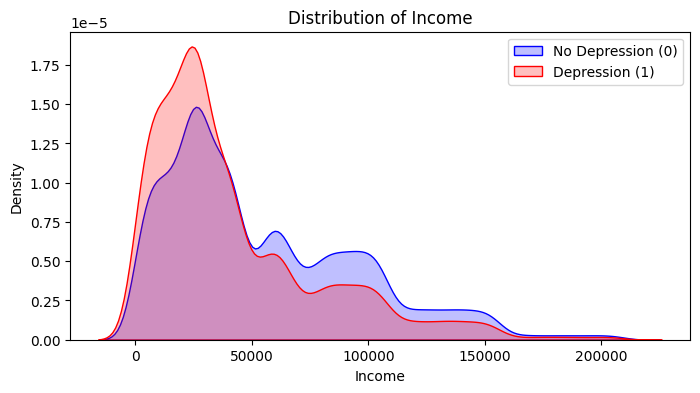

C:\Users\ciaranh\AppData\Local\Temp\ipykernel_19204\2746211763.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(class_0[feature], label='No Depression (0)', shade=True, color='blue', bw_adjust=1.5)
C:\Users\ciaranh\AppData\Local\Temp\ipykernel_19204\2746211763.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(class_1[feature], label='Depression (1)', shade=True, color='red', bw_adjust=1.5)


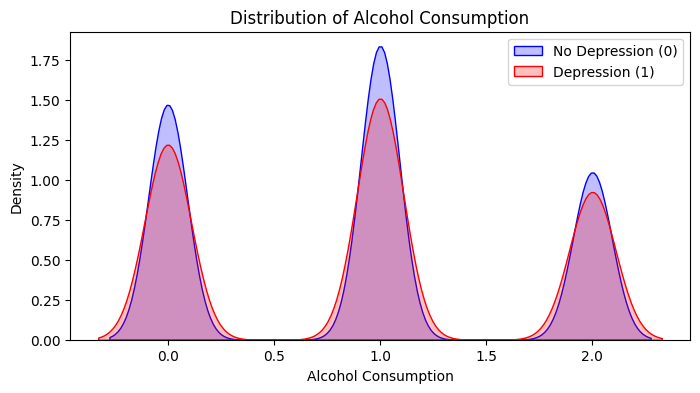

C:\Users\ciaranh\AppData\Local\Temp\ipykernel_19204\2746211763.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(class_0[feature], label='No Depression (0)', shade=True, color='blue', bw_adjust=1.5)
C:\Users\ciaranh\AppData\Local\Temp\ipykernel_19204\2746211763.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(class_1[feature], label='Depression (1)', shade=True, color='red', bw_adjust=1.5)


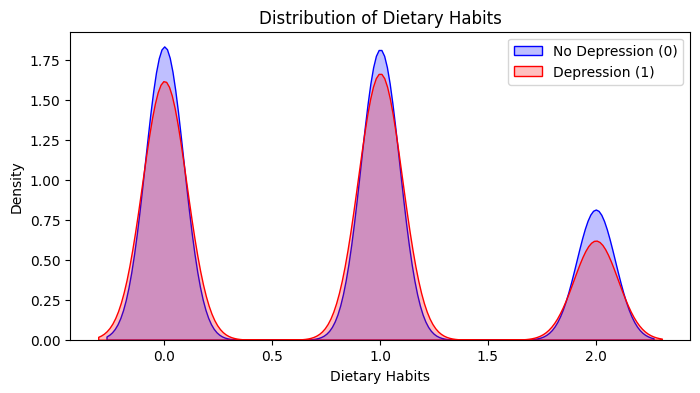

C:\Users\ciaranh\AppData\Local\Temp\ipykernel_19204\2746211763.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(class_0[feature], label='No Depression (0)', shade=True, color='blue', bw_adjust=1.5)
C:\Users\ciaranh\AppData\Local\Temp\ipykernel_19204\2746211763.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(class_1[feature], label='Depression (1)', shade=True, color='red', bw_adjust=1.5)


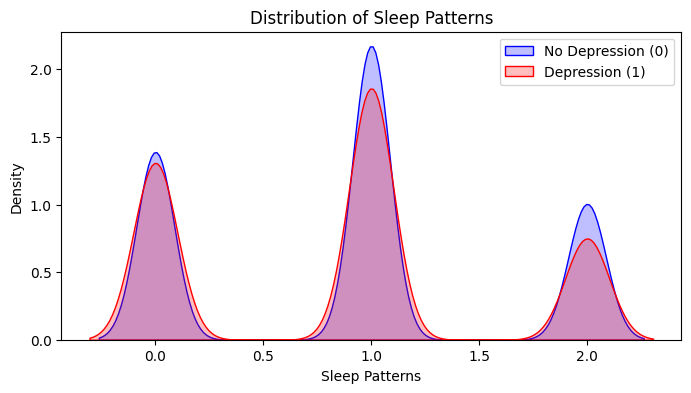

C:\Users\ciaranh\AppData\Local\Temp\ipykernel_19204\2746211763.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(class_0[feature], label='No Depression (0)', shade=True, color='blue', bw_adjust=1.5)
C:\Users\ciaranh\AppData\Local\Temp\ipykernel_19204\2746211763.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(class_1[feature], label='Depression (1)', shade=True, color='red', bw_adjust=1.5)


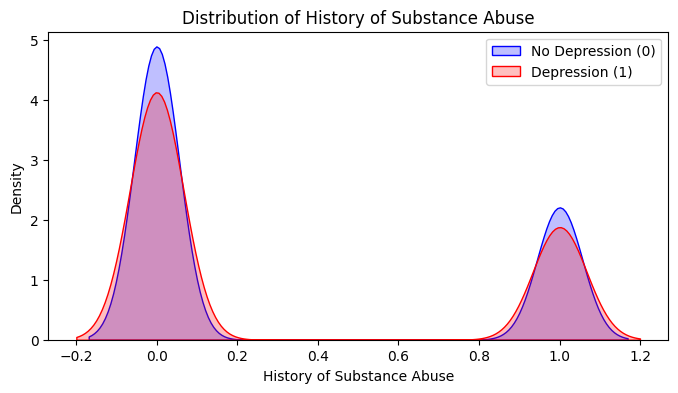

C:\Users\ciaranh\AppData\Local\Temp\ipykernel_19204\2746211763.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(class_0[feature], label='No Depression (0)', shade=True, color='blue', bw_adjust=1.5)
C:\Users\ciaranh\AppData\Local\Temp\ipykernel_19204\2746211763.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(class_1[feature], label='Depression (1)', shade=True, color='red', bw_adjust=1.5)


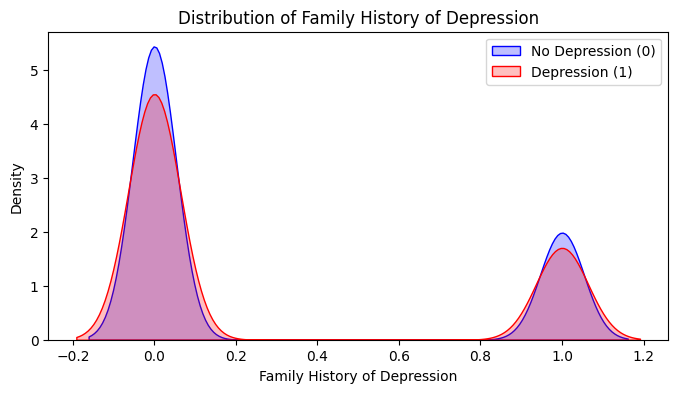

C:\Users\ciaranh\AppData\Local\Temp\ipykernel_19204\2746211763.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(class_0[feature], label='No Depression (0)', shade=True, color='blue', bw_adjust=1.5)
C:\Users\ciaranh\AppData\Local\Temp\ipykernel_19204\2746211763.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(class_1[feature], label='Depression (1)', shade=True, color='red', bw_adjust=1.5)


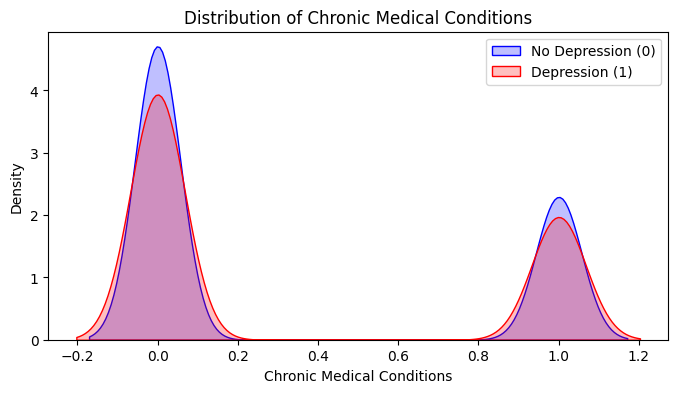

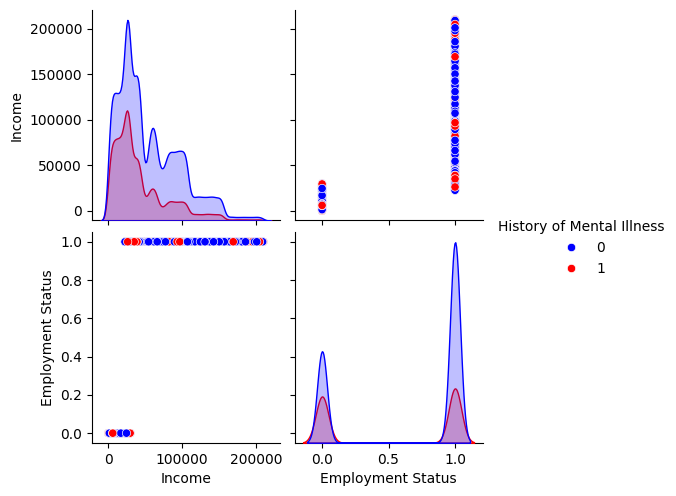

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

distribution_check = currated_dataset.copy()

# Separate data by classes
class_0 = distribution_check[distribution_check['History of Mental Illness'] == 0]
class_1 = distribution_check[distribution_check['History of Mental Illness'] == 1]

# Plot distribution for each feature
for feature in distribution_check.columns:
    if feature != 'History of Mental Illness':  # Skip the target column
        plt.figure(figsize=(8, 4))
        sns.kdeplot(class_0[feature], label='No Depression (0)', shade=True, color='blue', bw_adjust=1.5)
        sns.kdeplot(class_1[feature], label='Depression (1)', shade=True, color='red', bw_adjust=1.5)
        plt.title(f'Distribution of {feature}')
        plt.legend()
        plt.show()

# Pairplot to visualize feature interactions (if there aren't too many features)
selected_features = ['Income', 'Employment Status']  # Replace with relevant features
sns.pairplot(distribution_check, hue='History of Mental Illness', vars=selected_features, diag_kind='kde', palette={0: 'blue', 1: 'red'})
plt.show()


The results show a high degree of overlap. Income and Employment Status exhibit least overlap, which aligns with our results with them being ranked highly for feature importance.

Given the limited value of the remaining feautures, it seems reasonable to exclude all features/noise other than Employment Status and Income.

In [17]:
# Insert no training run


# Conclusion
Removing features does not seem to have a huge affect on the model peformance. 

1. Redundant Information Was Not Affecting the Model
The XGBoost model may be handling the correlated the features well, therefore correlated features are not introducing instability or noise into your model. That said, given those features have little predictive power, their inclusion is not necessary.

2. Features Have Limited Predictive Power
The Features are not the primary drivers of the target variable (e.g., depression may depend on unmeasured factors like genetics or social dynamics). We may need to source additional features that could improve the model, e.g., healthcare history or stress levels.

Conclusion. Mental illness is a complex condition. What we may be seeing here in the data, is that trying to ascribe features such as physical activity, may be too simplistic in explaining the phenomena. Mental illness is as much environmental as it is genetic, and therefore it's triggers are poorly understood. 